In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from utils import Geometry, simulate_events, classify_events

# radius of a circle that contains all the grid points
radius = 2.3
geometry = Geometry.create(spacing=1, radius=radius, jitter=0.1)

[1.64836677] [0.14447509] [[0.14404064 0.01119576]]


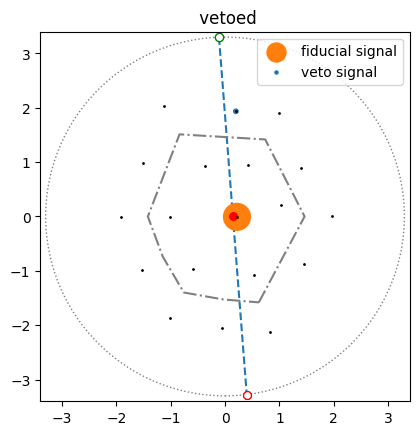

In [5]:
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

ax = plt.gca()
ax.scatter(*geometry.xy.T, color="k", s=1, zorder=10)
ax.add_artist(Circle((0, 0), radius + 1, facecolor="None", edgecolor="grey", ls=":"))

plt.plot(*geometry.fiducial_boundary.T, color="grey", ls="-.")

size_ = 100

angle = np.random.uniform(0, 2 * np.pi, size=size_)
impact = np.random.uniform(-radius + 1, radius - 1, size=size_)

enter, exit, loss_position, fiducial_signal, veto_signal = simulate_events(
    geometry, radius + 1, angle, impact, np.ones(size_) * 3
)
in_volume, triggered, vetoed = classify_events(
    geometry, loss_position, fiducial_signal, veto_signal
)

idx = np.where(in_volume & triggered)[0][0]
mask = slice(idx, idx + 1)

for start, end in zip(enter[mask], exit[mask]):
    ax.add_artist(Line2D([start[0], end[0]], [start[1], end[1]], ls="--", zorder=0))

ax.scatter(*enter[mask].T, marker="o", edgecolor="g", facecolor="w")
ax.scatter(*exit[mask].T, marker="8", edgecolor="r", facecolor="w")
ax.scatter(loss_position[mask, 0], loss_position[mask, 1], marker="*", color="C1")
ax.scatter(loss_position[mask, 0], loss_position[mask, 1], marker="*", color="C1")
ax.scatter(
    *geometry.fiducial_xy.T,
    s=10*np.power(fiducial_signal[mask], 1 / 2),
    facecolor="C1",
    label="fiducial signal",
)
d = np.stack((-np.cos(angle), -np.sin(angle)), axis=-1)
closest_approach = impact[..., None] * np.stack((-d[..., 1], d[..., 0]), axis=-1)
ax.scatter(*closest_approach[mask].T, s=30, color='red')

print(angle[mask], impact[mask], closest_approach[mask] )

ax.scatter(
    *geometry.veto_xy.T,
    s=10*np.power(veto_signal[mask], 1 / 2),
    facecolor="C0",
    #
    label="veto signal",
)
ax.set_title(f'{"not " if not vetoed[mask] else ""} vetoed')

ax.set_aspect("equal")
ax.set_ylim(-radius-1.1, radius+1.1)
ax.set_xlim(-radius-1.1, radius+1.1)
ax.legend()


## Generating an event sample

In [7]:
size = 1000000

# sample uniformly in direction
angle = np.random.uniform(0, 2 * np.pi, size=size)
# sample uniformly in impact parameter
impact = np.random.uniform(-radius - 1, radius + 1, size=size)
# particle "energy"
log_energy = np.random.uniform(2, 5, size=size)
#log_energy = np.random.uniform(0.1, 10, size=size)

enter, exit, loss_position, fiducial_signal, veto_signal = simulate_events(
    geometry, radius + 1, angle, impact, log_energy
)
in_volume, triggered, vetoed = classify_events(
    geometry, loss_position, fiducial_signal, veto_signal
)
unvetoed = triggered & ~vetoed

d = np.stack((-np.cos(angle), -np.sin(angle)), axis=-1)
closest_approach = impact[..., None] * np.stack((-d[..., 1], d[..., 0]), axis=-1)

df = pd.DataFrame(
    {
        "angle": angle,
        "impact": impact,
        "log_energy": log_energy,
        "closest_approach_x":closest_approach[...,0],
        "closest_approach_y":closest_approach[...,1],
        "in_volume": in_volume,
        "triggered": triggered,
        "vetoed": vetoed,
    }
)

df[unvetoed].to_csv("background_events.csv", index=False)
# also dump the geometry e.g. for later evaluation in a different notebook
geometry.dump("geometry.npz")


## Train a NN to classify the unvetoed events

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn import model_selection

variables = ['angle', 'impact', 'log_energy'] 
variables = ['angle', 'impact', 'log_energy' ]
labels    = [ 'vetoed', ]

df[labels[:-1]] = df[labels[:-1]].astype(bool)
df['undetected'] = (~df['triggered']) & (~df['vetoed'])
df[labels] = df[labels].astype(int)

presel = abs(df['impact']<2) & (df['log_energy']<4.5)

df_train, df_test = model_selection.train_test_split(df[:],  test_size=0.5, train_size=0.5)

X_train = df_train[variables]
Y_train = df_train[labels]
X_test = df_test[variables]
Y_test = df_test[labels]



def make_model(n_variables, n_labels=3):
    model = tf.keras.Sequential([
                layers.Dense(32, activation='relu', input_shape=(n_variables, ) ),
                layers.Dense(8, activation='relu',),
                layers.Dense(4, activation='relu',),
                layers.Dense(n_labels, activation='softmax')
    ])
    return model

model = make_model(len(variables), len(labels) )

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


y_prime = np.sum(Y_train.to_numpy()*[0,1,2], axis=-1)
y_prime = y_prime[:,np.newaxis]
history = model.fit(X_train.to_numpy(), y_prime, epochs=5)




In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn import model_selection


variables = ['angle', 'impact', 'log_energy' ]
variables += ['closest_approach_x', 'closest_approach_y']

df['unvetoed'] = df['triggered'] & ~df['vetoed']
labels    = [ 'unvetoed', ]

presel = abs(df['impact']<2) & (df['log_energy']<4.5)


# split train and test datasets
df_train, df_test = model_selection.train_test_split(df[:300_000],  test_size=0.5, train_size=0.5)

X_train = df_train[variables]
Y_train = df_train[labels]
X_test = df_test[variables]
Y_test = df_test[labels]



def make_model(n_variables, n_labels=1):
    activation = 'relu'
    model = tf.keras.Sequential([
                 layers.Dense(128, activation=activation, input_shape=(n_variables, ) ),
                 layers.Dense(64, activation=activation,),
                 layers.Dense(32, activation=activation,),
                 layers.Dense(16, activation=activation,),
                 layers.Dense(8, activation=activation,),
                 layers.Dense(n_labels, activation='sigmoid')
    ])
    return model

model = make_model(len(variables), len(labels) )

metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.TruePositives(name='tp'),
]

model.compile(
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=metrics)


n_pos = float(np.sum(Y_train==1))
n_neg = float(np.sum(Y_train==0))
n_tot = float(np.sum(Y_train))

class_weight = {1:n_tot/(2*n_pos), 0:n_tot/(2*n_neg) }
class_weight = {1:50.0, 0:0.5}

history = model.fit(X_train, Y_train, class_weight=class_weight, epochs=50)







2023-06-23 14:21:10.221081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 14:21:10.540447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-23 14:21:10.540497: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-23 14:21:12.318060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/50
4688/4688 [==============================] - 13s 2ms/step - loss: 0.4473 - accuracy: 0.7037
Epoch 2/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3711 - accuracy: 0.7531
Epoch 3/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3612 - accuracy: 0.7580
Epoch 4/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3467 - accuracy: 0.7627
Epoch 5/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3487 - accuracy: 0.7609
Epoch 6/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3628 - accuracy: 0.7635
Epoch 7/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3432 - accuracy: 0.7655
Epoch 8/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3423 - accuracy: 0.7654
Epoch 9/50
4688/4688 [==============================] - 10s 2ms/step - loss: 0.3449 - accuracy: 0.7688
Epoch 10/50
4688/4688 [==============================] - 9s 2ms/step - lo

In [ ]:
### model diagnostics:

In [52]:
model.save("Model_6L_Binary/model.h5")
model.save_weights('./Model_6L_Binary/weights.h5')

<Axes: >

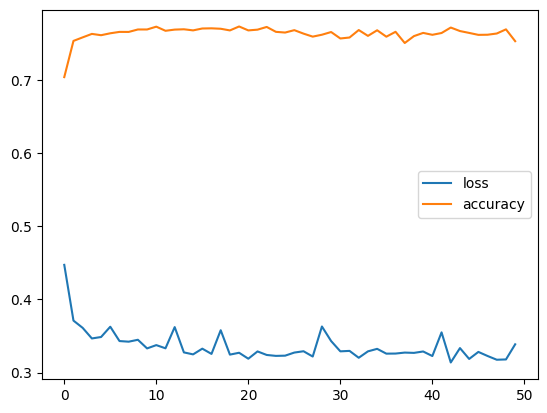

In [9]:
pd.DataFrame(history.history).plot()

In [37]:
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

4688/4688 [==============================] - 6s 1ms/step



    number of true unvetoed: 1415.0
      correctly labeled:     0.99%
      incorrectly labeled:   0.01%
    
    


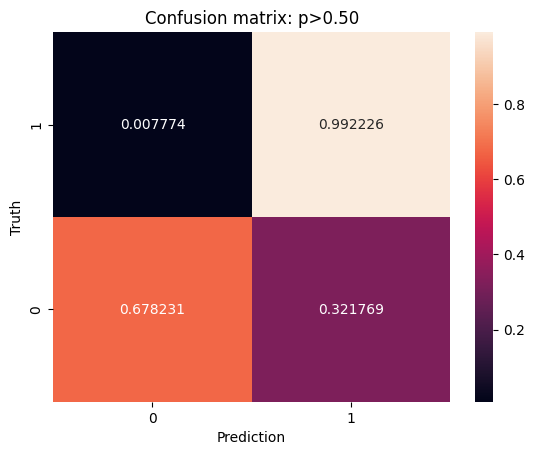

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion(labels, pred, prob=0.5):
    pred_prob = pred>prob
    conf_matrix = confusion_matrix(labels, pred_prob, normalize='true')
    fig, ax = plt.subplots()
    ax_ = sns.heatmap(conf_matrix, annot=True, fmt="f")
    ax.invert_yaxis()
    ax.set_title('Confusion matrix: p>{:.2f}'.format(prob))
    ax.set_ylabel('Truth')
    ax.set_xlabel('Prediction')

    cm = conf_matrix
    
    n_true = float((labels==1).sum())
    print(f"""
    number of true unvetoed: {n_true}
      correctly labeled:     { cm[1][1]:0.2f}%
      incorrectly labeled:   { cm[1][0]:0.2f}%
    
    """)
    
#pred = model.predict(X_test) 
plot_confusion(Y_test, pred_test, prob=0.5)

In [40]:
df_test = X_test[:]
df_test['pred'] = pred_test
df_test['label'] = Y_test
df_test = df_test.sort_values(by='label', ascending=False)

df_train = X_train[:]
df_train['pred'] = pred_train
df_train['label'] = Y_train
df_train = df_train.sort_values(by='label', ascending=False)



/tmp/ipykernel_75485/3338081213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = pred_test
/tmp/ipykernel_75485/3338081213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'] = Y_test
/tmp/ipykernel_75485/3338081213.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Text(0, 0.5, 'closest_approach_y')

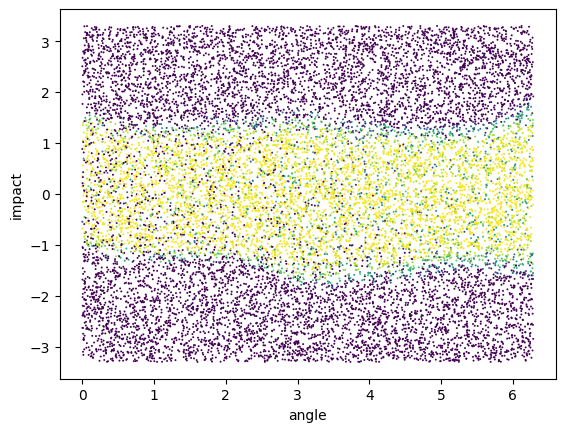

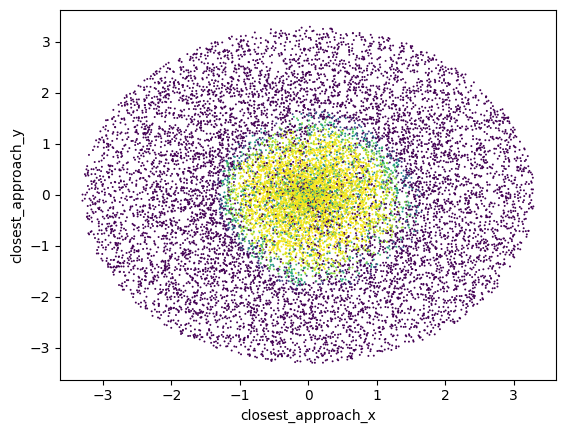

In [53]:




n_unvetoed = int((df_test['label']==True).sum())

df_test_ = pd.concat([df_test.head(n_unvetoed), df_test.tail(10*n_unvetoed)])

fig, ax = plt.subplots()
v1='angle'
v2='impact'
ax.scatter(df_test_[v1], df_test_[v2], c=df_test_['pred'], edgecolor='white', linewidth=0.001, s=2)
ax.set_xlabel(v1)
ax.set_ylabel(v2)


fig, ax = plt.subplots()
v1='closest_approach_x'
v2='closest_approach_y'
ax.scatter(df_test_[v1], df_test_[v2], c=df_test_['pred'], edgecolor='white', linewidth=0.001, s=2)
ax.set_xlabel(v1)
ax.set_ylabel(v2)



Text(0.5, 0, 'score')

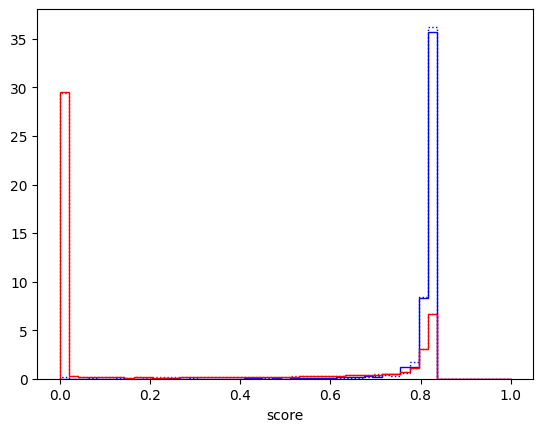

In [51]:

fig, ax = plt.subplots()

bins=np.linspace(0,1,50)

hist_opts = dict(histtype='step', fill=False, bins=bins, density=True)

ax.hist( df_train.query('label==True')['pred'], edgecolor='blue', **hist_opts )
ax.hist( df_train.query('label==False')['pred'], edgecolor='red', **hist_opts )

ax.hist( df_test.query('label==True')['pred'], edgecolor='blue', ls=':', **hist_opts )
ax.hist( df_test.query('label==False')['pred'], edgecolor='red', ls=':', **hist_opts )

ax.set_xlabel("score")


In [166]:
(triggered & ~vetoed).sum()/len(df), (triggered & ~vetoed).sum()/df.size , df.size/len(df)

(0.010081, 0.0016801666666666666, 6.0)